In [1]:
"""
Goal:
1. Analyze results from an A/B test.
2. Design an algorithm to automate some steps.

Problem Statement:
Spain-based users have much higher conversion rate than other Spanish-speaking country. Translation could be one 
reason. Test: each country would have its one translation written by a local. But test failed. 
Non-localized translation was doing better.

1. Confirm that the test is actually negative.
2. Explain why that might be happening. Are the localized translations really worse?
3. If you identified what was wrong, design an algorithm that would return FALSE if the
same problem is happening in the future and TRUE if everything is good and the results can be trusted.

Author:@surancy
Date:07/07/2019
"""

'\nGoal:\n1. Analyze results from an A/B test.\n2. Design an algorithm to automate some steps.\n\nProblem Statement:\nSpain-based users have much higher conversion rate than other Spanish-speaking country. Translation could be one \nreason. Test: each country would have its one translation written by a local. But test failed. \nNon-localized translation was doing better.\n\n1. Confirm that the test is actually negative.\n2. Explain why that might be happening. Are the localized translations really worse?\n3. If you identified what was wrong, design an algorithm that would return FALSE if the\nsame problem is happening in the future and TRUE if everything is good and the results can be trusted.\n\nAuthor:@surancy\nDate:07/07/2019\n'

In [2]:
# Setting up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# to suppress warnings using sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# load data
df_test = pd.read_csv("test_table.csv")
df_user = pd.read_csv("user_table.csv")

In [5]:
# Inspection and Data Preparation
df_test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


test: 0 being control and 1 being test. Test see new translation, control keep the old. Spain-based users are all in control group.

In [6]:
df_user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [7]:
# check if there is any user id missing in either dataset
print("How many examples not caught by both tables: ",len(pd.merge(df_user, df_test, how='outer', on="user_id")) -
     len(pd.merge(df_user, df_test, how='inner', on="user_id")))

How many examples not caught by both tables:  454


So there are 454 data not being recognized by both dataset, meaning that 454 user information are missing in either test data or user information table. Which one is it? Let's find out.

In [8]:
len(pd.merge(df_user, df_test, how='left', on="user_id"))

452867

In [9]:
len(pd.merge(df_user, df_test, how='right', on="user_id"))

453321

So we know that test data have some records that are lacking in any user information. Let's join them so that we don't lose any data.

<mark>**When joining, we have to be careful to do not lose the user ids in the test table, but not in the user table.**</mark>

In [30]:
df_all = pd.merge(df_user, df_test, how='right', on="user_id")

In [31]:
df_all.shape

(453321, 12)

In [11]:
df_all.head()

,user_id,sex,age,country,date,source,device,browser_language,ads_channel,browser,conversion,test
0,765821,M,20,Mexico,2015-12-02,Ads,Mobile,ES,Yahoo,Android_App,0,1
1,343561,F,27,Nicaragua,2015-12-04,Ads,Web,ES,Facebook,Safari,0,0
2,118744,M,23,Colombia,2015-11-30,Ads,Mobile,ES,Facebook,Android_App,0,1
3,987753,F,27,Venezuela,2015-12-04,SEO,Web,ES,NaN,IE,0,1
4,554597,F,20,Spain,2015-12-04,Direct,Web,ES,NaN,Chrome,0,0


In [32]:
# inspect variables
df_all.describe(include = "object")

,sex,country,date,source,device,browser_language,ads_channel,browser
count,452867,452867,453321,453321,453321,453321,181877,453321
unique,2,17,5,3,2,3,5,7
top,M,Mexico,2015-12-04,Ads,Web,ES,Facebook,Android_App
freq,264485,128484,141163,181877,251565,377547,68425,155135


In [33]:
df_all["age"].describe()

count    452867.000000
mean         27.130740
std           6.776678
min          18.000000
25%          22.000000
50%          26.000000
75%          31.000000
max          70.000000
Name: age, dtype: float64

Distribution of age seems fine, without suspicious age data.

In [34]:
# check missing value
df_all.isnull().sum()

user_id                  0
sex                    454
age                    454
country                454
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

So it seems that ads_channel has most missing values, and more than 50% are missing values. The missing sex, age, country information are due to the lack of user information from user table when joining. Let's see what insight this ads channel gives us first before we decide what to do with the missing value. 

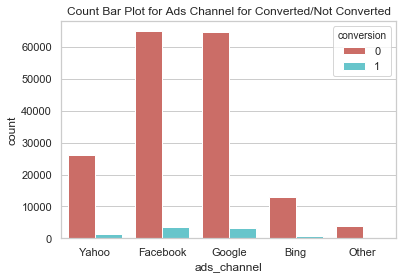

In [35]:
sns.set(style="whitegrid")
ax = sns.countplot(x="ads_channel", hue="conversion", data=df_all,palette = "hls").set_title("Count Bar Plot for Ads Channel for Converted/Not Converted")

With Facebook and Google being two most popular ads channel, let's now see which one ads channel is more pruned to convert.

In [36]:
def plot_conditional(feature_name, df_convert, df, figsizex, figsizey, title):
    # add sorting function
    probability = []
    feature_values = list(df.groupby(feature_name).groups.keys())

    for v in feature_values:
        probability.append(len(df_convert.groupby(feature_name).get_group(v)) / len(df.groupby(feature_name).get_group(v)))

    print(probability)

    # visualization
    height = probability
    bars = feature_values
    colors = ["orange","lightpink","olive","lightblue","salmon"]
    y_pos = np.arange(len(bars))

    plt.figure(figsize = (figsizex,figsizey))
    plt.bar(y_pos,height, color = colors)
    plt.xticks(y_pos, bars)
    plt.title(title)
    plt.ylabel("Probability")
    plt.show() # supress messages

In [37]:
converted = df_all[(df_all["conversion"] == 1)]

[0.04887135656366426, 0.05077091706247717, 0.049163977706072164, 0.044358727097396335, 0.05026426098049936]


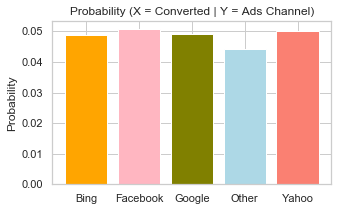

In [38]:
plot_conditional("ads_channel",converted,df_all,5,3,"Probability (X = Converted | Y = Ads Channel)")

Intersting! So it appears that all ads channel are actually almost equal likely to conversion. With this finding, we can remove the ads channel variable from our data for further analysis and modeling for the conversion.

In [39]:
df_all = df_all.drop(columns = "ads_channel")

In [40]:
df_all.shape

(453321, 11)

# Validate the test result

In [41]:
test_group = df_all[(df_all["test"] == 1)]
control_group = df_all[(df_all["test"] == 0)]

In [44]:
a = len(control_group[(control_group["conversion"] == 1)]) / len(control_group)
a

0.055178690306651276

In [45]:
b = len(test_group[(test_group["conversion"] == 1)]) / len(test_group)
b

0.043424713982118966

In [46]:
print("% difference in test and control group: {}%"
      .format(round(((b - a) * 100 / a),4)))

% difference in test and control group: -21.3017%


Based on the above matrix, the test group indeed does worse than control group in terms of conversion rate. So the test result is negative and non-localized translator has a better performance based on the conversion result. Testing group has the conversion rate decreased by ~20%.

So what caused the decrement in conversion rate after adopting localized translator? Some possibilities:
- the problem of the new translator. Is the localized translator really localized? We can ask for the suggestion from a third-party to see if the localized translator is functioning well.
- other factors affect the test group performance, not controlling the similar variables across test group and control group

Let's see whether the Spain users convert more than other countries, test group or not.

In [89]:
test_group_spain = df_all[(df_all["country"].isnull() == False) & (df_all["test"] == 0) & (df_all["country"] == "Spain")]
test_group_spain_convert = test_group_spain[(test_group_spain["conversion"] == 1)]

In [86]:
all_group_non_spain = df_all[(df_all["country"].isnull() == False) & (df_all["country"] != "Spain")]
all_group_non_spain_convert = all_group_non_spain[(all_group_non_spain["conversion"] == 1)]

In [91]:
len(test_group_spain_convert) / len(test_group_spain)

0.07971882121200417

In [92]:
len(all_group_non_spain_convert) / len(all_group_non_spain)

0.04566613062069137

So we know that Spain users convert more than all other countries. Let's further divide users in all other countries based on their test/control group to see if there's anything go wrong with the experiment.

In [98]:
all_group_non_spain_test = all_group_non_spain[(all_group_non_spain["test"] == 1)]
all_group_non_spain_control = all_group_non_spain[(all_group_non_spain["test"] == 0)]

In [113]:
# do a Welch's 2 sample t-test (assume unequal sample sizes)
# https://en.wikipedia.org/wiki/Welch's_t-test
# t-score larger than 0.05 or 0.1, we cannot reject the null hypothesis of identical average scores. 
# If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, 
# then we reject the null hypothesis of equal averages.
from scipy import stats
from statistics import mean

In [115]:
stats.ttest_ind(all_group_non_spain_test["conversion"].values.tolist(), all_group_non_spain_control["conversion"].values.tolist(),
                axis = 0, equal_var = False)

Ttest_indResult(statistic=-7.353895203080277, pvalue=1.928917857779903e-13)

In [114]:
mean(all_group_non_spain_test["conversion"].values.tolist())

0.043411161678422794

In [116]:
mean(all_group_non_spain_control["conversion"].values.tolist())

0.04829179055749524

In [118]:
(0.043411161678422794 - 0.04829179055749524) *100 / 0.04829179055749524

-10.106539481615755

So based on the t-test result we reject the null hypothesis of equal averages for control and test group of non-spain users. The t-test result is far from normal range. Therefore, there must be something wrong in the test set/control set for users in non-spain countries because they have different mean. Test group has a 10% lower conversion average than the control group. That 10% drop would be dramatic if it were true. The most likely reason for weird A/B test results are:
    - We didn’t collect enough data.
    - Some bias has been introduced in the experiment so that test/control people are not really random.
    
Let's take a further look into our data to see whether the test design is off.

# Exploratory Data Analysis

In [29]:
converted = df_all[(df_all["conversion"] == 1)]
not_converted = df_all[(df_all["conversion"] == 0)]

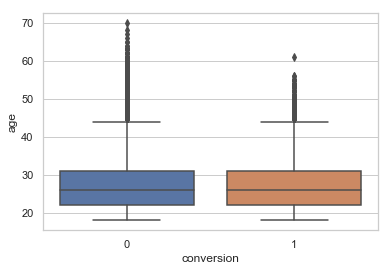

In [25]:
ax = sns.boxplot(x = "conversion", y = "age",data = df_all)

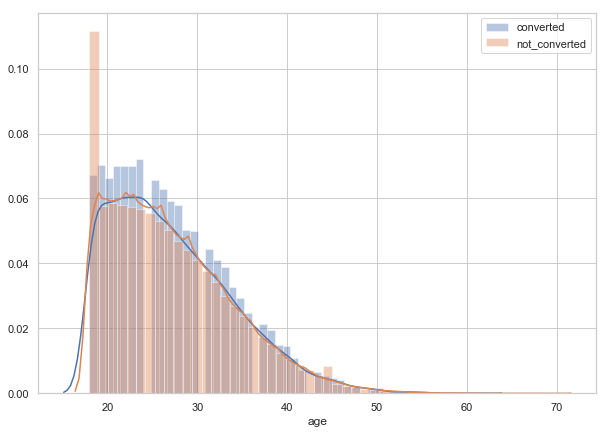

In [48]:
from scipy.stats import norm
plt.figure(figsize = (10,7))
sns.distplot(converted["age"],kde=True)
sns.distplot(not_converted["age"],kde = True)
plt.legend(labels=['converted','not_converted'])
plt.show()

Not converted users have a longer tail that is more skewed to right, meaning they have older user base. Meanwhile, converted users have larger probability of young users (20 ~ 35 yrs).

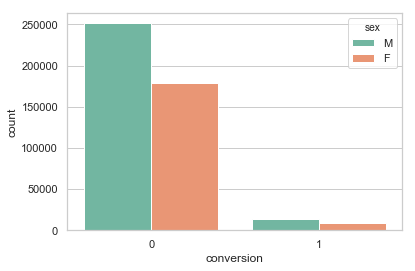

In [30]:
ax = sns.countplot(x = "conversion", hue = "sex", data = df_all,palette = "Set2")

In [42]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 10})

[0.013994393683264503, 0.04863358504135203, 0.04970360237118103, 0.05133185349611543, 0.05349406667922396, 0.049072035231204784, 0.05076452599388379, 0.04965289256198347, 0.04925303454715219, 0.05034089847763146, 0.05339878030641083, 0.0480890913692736, 0.04886348169320811, 0.05025842095883087, 0.07971882121200417, 0.01282051282051282, 0.049666188307231546]


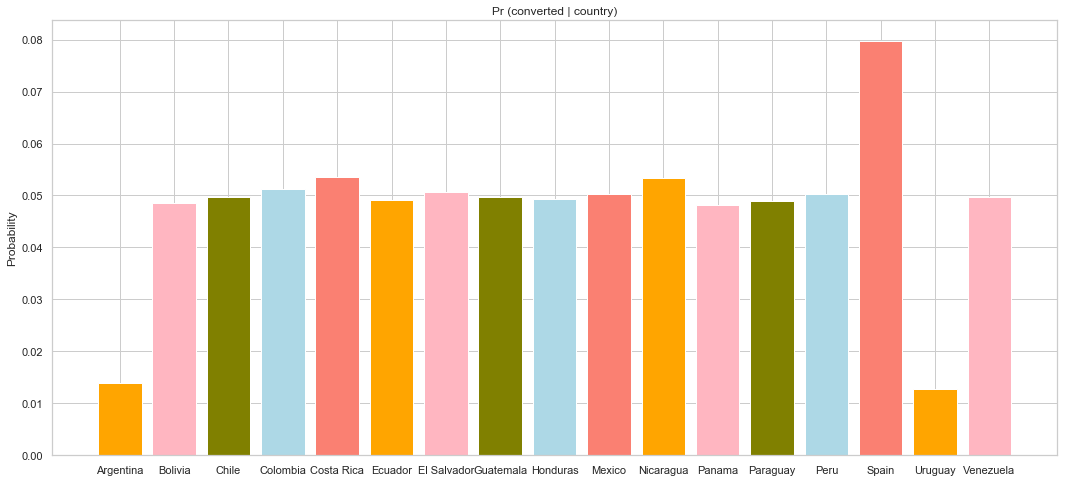

In [120]:
plot_conditional("country",converted,df_all,18,8,"Pr (converted | country)")

So it seems that Spain users are more pruned to convert than others, and Uruguay and Argentina users are less pruned to convert, while the rest countries perform almost equal likely.

In [136]:
# Time analysis
df_all.groupby("date")["date"].describe()

,count,unique,top,freq
date,,,,
2015-11-30,71025,1,2015-11-30,71025
2015-12-01,70991,1,2015-12-01,70991
2015-12-02,70649,1,2015-12-02,70649
2015-12-03,99493,1,2015-12-03,99493
2015-12-04,141163,1,2015-12-04,141163


In [141]:
test_group.groupby(["date","conversion"]).describe()

user_id                                        \
                         count           mean            std     min   
date       conversion                                                  
2015-11-30 0           32396.0  499790.548586  288585.654344     5.0   
           1            1487.0  488538.080027  288413.515614   221.0   
2015-12-01 0           32473.0  500164.665384  288753.685414    68.0   
           1            1402.0  507168.603424  286429.980851   357.0   
2015-12-02 0           32065.0  497710.029315  289308.500942    15.0   
           1            1484.0  508487.740566  284761.267668  1078.0   
2015-12-03 0           45339.0  499864.153201  288894.464529     3.0   
           1            2081.0  496178.513695  294495.553553   305.0   
2015-12-04 0           64331.0  499555.190546  287713.579949    13.0   
           1            2925.0  498116.987009  286192.187970   706.0   

                                                                     age  \
                             25%       50%        75%       max    count   
date       conversion                                                      
2015-11-30 0           248992.00  498004.0  748334.75  999999.0  32359.0   
           1           233386.50  476466.0  739683.00  999563.0   1485.0   
2015-12-01 0           251319.00  500751.0  749056.00  999984.0  32440.0   
           1           262805.25  511857.0  749239.75  999921.0   1400.0   
2015-12-02 0           244645.00  500132.0  748778.00  999863.0  32035.0   
           1           269663.25  509809.0  753582.50  998489.0   1482.0   
2015-12-03 0           249685.50  498402.0  750121.00  999998.0  45303.0   
           1           241872.00  500258.0  750831.00  999929.0   2080.0   
2015-12-04 0           251334.00  498608.0  748670.50  999977.0  64270.0   
           1           248244.00  506079.0  735413.00  999624.0   2920.0   

                                  ...                 test                 \
                            mean  ...   75%   max    count mean  std  min   
date       conversion             ...                                       
2015-11-30 0           27.110603  ...  31.0  65.0  32396.0  1.0  0.0  1.0   
           1           27.033670  ...  31.0  53.0   1487.0  1.0  0.0  1.0   
2015-12-01 0           27.079069  ...  31.0  70.0  32473.0  1.0  0.0  1.0   
           1           27.290714  ...  32.0  55.0   1402.0  1.0  0.0  1.0   
2015-12-02 0           27.132293  ...  31.0  60.0  32065.0  1.0  0.0  1.0   
           1           27.504723  ...  32.0  56.0   1484.0  1.0  0.0  1.0   
2015-12-03 0           27.122972  ...  31.0  63.0  45339.0  1.0  0.0  1.0   
           1           26.990385  ...  31.0  55.0   2081.0  1.0  0.0  1.0   
2015-12-04 0           27.123712  ...  31.0  64.0  64331.0  1.0  0.0  1.0   
           1           26.923288  ...  31.0  61.0   2925.0  1.0  0.0  1.0   

                                           
                       25%  50%  75%  max  
date       conversion                      
2015-11-30 0           1.0  1.0  1.0  1.0  
           1           1.0  1.0  1.0  1.0  
2015-12-01 0           1.0  1.0  1.0  1.0  
           1           1.0  1.0  1.0  1.0  
2015-12-02 0           1.0  1.0  1.0  1.0  
           1           1.0  1.0  1.0  1.0  
2015-12-03 0           1.0  1.0  1.0  1.0  
           1           1.0  1.0  1.0  1.0  
2015-12-04 0           1.0  1.0  1.0  1.0  
           1           1.0  1.0  1.0  1.0  

[10 rows x 24 columns]

In [142]:
control_group.groupby(["date","conversion"]).describe()

user_id                                                 \
                         count           mean            std    min       25%   
date       conversion                                                           
2015-11-30 0           35011.0  500056.471966  288340.514459    2.0  250308.5   
           1            2131.0  502155.802440  292988.007100   82.0  244241.5   
2015-12-01 0           35126.0  497875.215510  288479.933720   25.0  246966.0   
           1            1990.0  505239.773869  288469.378378  705.0  260325.0   
2015-12-02 0           35046.0  500831.099669  289031.188046    1.0  248310.0   
           1            2054.0  491908.804284  295706.286318  171.0  229965.0   
2015-12-03 0           49152.0  500733.338399  288189.846206   43.0  251241.5   
           1            2921.0  504270.281410  291222.923541  190.0  249794.0   
2015-12-04 0           69907.0  500950.203542  288986.961057   12.0  250720.0   
           1            4000.0  504839.373000  291018.678990  579.0  251608.5   

                                                           age             \
                            50%        75%        max    count       mean   
date       conversion                                                       
2015-11-30 0           500544.0  748134.00   999980.0  34980.0  27.124900   
           1           512111.0  752683.00   999857.0   2124.0  27.042844   
2015-12-01 0           497085.0  747119.00  1000000.0  35088.0  27.144950   
           1           503196.0  754781.25   999906.0   1987.0  26.905385   
2015-12-02 0           503809.5  750799.25   999996.0  35014.0  27.157880   
           1           488369.0  748976.25   999325.0   2050.0  27.137073   
2015-12-03 0           501691.5  748643.75   999993.0  49099.0  27.119901   
           1           509768.0  761728.00   999989.0   2917.0  27.101131   
2015-12-04 0           500692.0  752041.50   999970.0  69835.0  27.163142   
           1           503054.0  763201.25   999392.0   3999.0  27.400350   

                       ...                 test                                \
                       ...   75%   max    count mean  std  min  25%  50%  75%   
date       conversion  ...                                                      
2015-11-30 0           ...  31.0  63.0  35011.0  0.0  0.0  0.0  0.0  0.0  0.0   
           1           ...  31.0  55.0   2131.0  0.0  0.0  0.0  0.0  0.0  0.0   
2015-12-01 0           ...  31.0  63.0  35126.0  0.0  0.0  0.0  0.0  0.0  0.0   
           1           ...  31.0  55.0   1990.0  0.0  0.0  0.0  0.0  0.0  0.0   
2015-12-02 0           ...  31.0  66.0  35046.0  0.0  0.0  0.0  0.0  0.0  0.0   
           1           ...  31.0  53.0   2054.0  0.0  0.0  0.0  0.0  0.0  0.0   
2015-12-03 0           ...  31.0  67.0  49152.0  0.0  0.0  0.0  0.0  0.0  0.0   
           1           ...  31.0  55.0   2921.0  0.0  0.0  0.0  0.0  0.0  0.0   
2015-12-04 0           ...  31.0  68.0  69907.0  0.0  0.0  0.0  0.0  0.0  0.0   
           1           ...  32.0  55.0   4000.0  0.0  0.0  0.0  0.0  0.0  0.0   

                            
                       max  
date       conversion       
2015-11-30 0           0.0  
           1           0.0  
2015-12-01 0           0.0  
           1           0.0  
2015-12-02 0           0.0  
           1           0.0  
2015-12-03 0           0.0  
           1           0.0  
2015-12-04 0           0.0  
           1           0.0  

[10 rows x 24 columns]

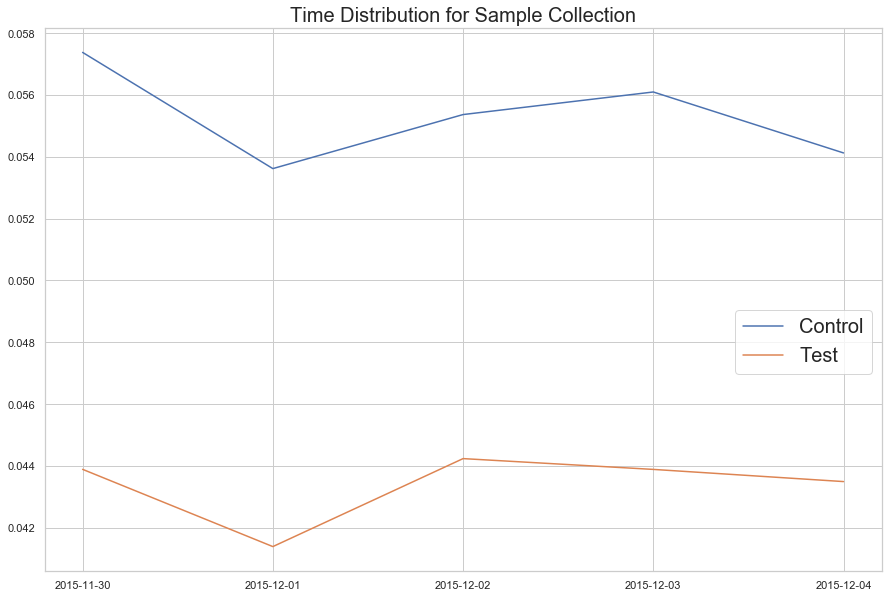

In [175]:
y = test_group.groupby(["date"])["conversion"].mean().values.tolist()
x = test_group.groupby(["date"])["conversion"].mean().index.tolist()
y1 = control_group.groupby(["date"])["conversion"].mean().values.tolist()

plt.figure(figsize = (15,10))
plt.plot(x,y1, label = "Control")
plt.plot(x,y,label = "Test")
plt.legend(fontsize = 20,bbox_to_anchor=(1, 0.5))
plt.title("Time Distribution for Sample Collection",fontsize = 20)
plt.show()

From the plot, we notice a couple of things:
1. Test has constantly been worse than control and there is relatively little variance across days. That
probably means that we do have enough data, but there was some bias in the experiment set up.
2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to
capture weekly patterns, 2 weeks would be much better.

In [163]:
# some eda for other variables

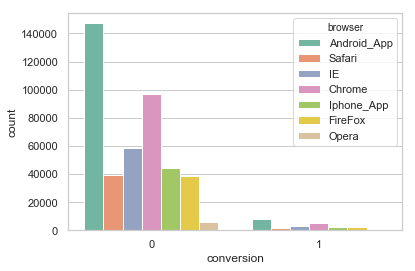

In [44]:
sns.set_context("notebook")
ax = sns.countplot(x = "conversion", hue = "browser", data = df_all, palette = "Set2")

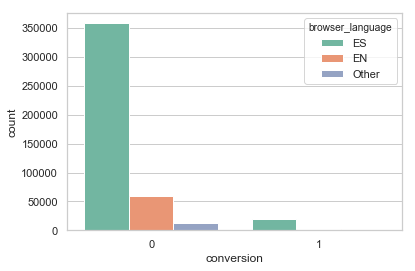

In [45]:
ax = sns.countplot(x = "conversion", hue = "browser_language", data = df_all, palette = "Set2")

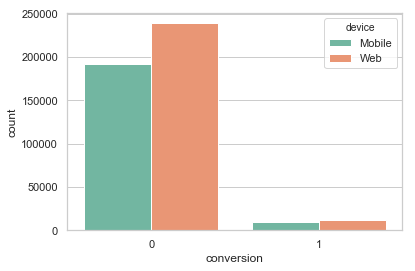

In [46]:
ax = sns.countplot(x = "conversion", hue = "device", data = df_all, palette = "Set2")

# Machine Learning
We need a model to automate the test result. So given features, the model should be able to pick up the conversion estimation. The model I plan to implement is logistic regression classifier, and decision tree.

## feature engineering

In [176]:
df_all = df_all.drop(columns = ["user_id"])

In [177]:
def mapValues(feature_name,df):
    feature_values = list(df.groupby(feature_name).groups.keys())
    values = [i for i in range(len(feature_values))]
    
    return dict(zip(feature_values,values))

In [178]:
df_all['sex'] = df_all['sex'].map({'F': 1, 'M': 0})

In [179]:
df_all['source'] = df_all['source'].map(mapValues("source",df_all))

In [180]:
df_all["country"] = df_all['country'].map(mapValues("country",df_all))

In [181]:
df_all["device"] = df_all['device'].map(mapValues("device",df_all))

In [182]:
df_all["browser_language"] = df_all['browser_language'].map(mapValues("browser_language",df_all))

In [183]:
df_all["browser"] = df_all['browser'].map(mapValues("browser",df_all))

In [184]:
df_all["date"] = df_all['date'].map(mapValues("date",df_all))

In [185]:
df_all.head()

,sex,age,country,date,source,device,browser_language,browser,conversion,test
0,0.0,20.0,9.0,2,0,0,1,0,0,1
1,1.0,27.0,10.0,4,0,1,1,6,0,0
2,0.0,23.0,3.0,0,0,0,1,0,0,1
3,1.0,27.0,16.0,4,2,1,1,3,0,1
4,1.0,20.0,14.0,4,1,1,1,1,0,0


In [218]:
df_all = df_all.dropna()

In [219]:
df_all.shape

(452867, 10)

In [220]:
lst = df_all.keys().tolist()[0:8]

In [221]:
lst.append("test")
lst

['sex',
 'age',
 'country',
 'date',
 'source',
 'device',
 'browser_language',
 'browser',
 'test']

In [222]:
from sklearn.model_selection import train_test_split

In [223]:
df_train,df_test = train_test_split(df_all, test_size=0.25, random_state=42)

In [224]:
x_train = df_train.loc[:,lst]

In [225]:
y_train = df_train.iloc[:,9]

In [226]:
x_test = df_test.loc[:,lst]
y_test = df_test.iloc[:,9]

In [227]:
# train model

In [228]:
# Decision Tree
from sklearn import tree

In [229]:
from sklearn.tree.export import export_text
decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=8)
decision_tree = decision_tree.fit(x_train, y_train)
r = export_text(decision_tree, feature_names=list(x_train))
print(r)

|--- test <= 0.50
|   |--- class: 0
|--- test >  0.50
|   |--- class: 1



In [233]:
print("overall accuracy on decision tree:", decision_tree.score(x_test,y_test))

overall accuracy on decision tree: 1.0


So we know that test/control group division is a deciding factor in predicting conversion rate, which further proves our previous finding that this test division has way too much effect on the final decision so there should be something wrong here. Thus, let's remove the test from input variables and see what can we got.

In [234]:
lst.remove("test")
lst

['sex',
 'age',
 'country',
 'date',
 'source',
 'device',
 'browser_language',
 'browser']

In [235]:
x_train = df_train.loc[:,lst]

In [236]:
x_test = df_test.loc[:,lst]

In [237]:
decision_tree = tree.DecisionTreeClassifier(random_state=0, max_depth=8)
decision_tree = decision_tree.fit(x_train, y_train)
r = export_text(decision_tree, feature_names=list(x_train))
print(r)

|--- country <= 13.50
|   |--- country <= 0.50
|   |   |--- browser <= 4.50
|   |   |   |--- date <= 1.50
|   |   |   |   |--- age <= 51.50
|   |   |   |   |   |--- age <= 48.50
|   |   |   |   |   |   |--- sex <= 0.50
|   |   |   |   |   |   |   |--- age <= 26.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- age >  26.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- sex >  0.50
|   |   |   |   |   |   |   |--- age <= 26.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- age >  26.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  48.50
|   |   |   |   |   |   |--- browser <= 1.50
|   |   |   |   |   |   |   |--- age <= 49.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- age >  49.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- browser >  1.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |-

So country, browser, date, and age are important to look into to inspect the test set up. We have already found some actionable suggestions for date.